In [1]:
from dask.diagnostics import ProgressBar
from dask.distributed import Client
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, PorterStemmer

import dask.dataframe as dd
import html
import matplotlib.pyplot as plt
import numpy as np
import psutil
import pandas as pd
import pickle as pkl
import re
import time

In [2]:
# Read the data
df_comments_1 = pd.read_pickle('C:/Users/Julia/Downloads/comments_typecasted_1.pkl')
df_comments_2 = pd.read_pickle('C:/Users/Julia/Downloads/comments_typecasted_2.pkl')
df_comments_3 = pd.read_pickle('C:/Users/Julia/Downloads/comments_typecasted_3.pkl')
df_comments_4 = pd.read_pickle('C:/Users/Julia/Downloads/comments_typecasted_4.pkl')
df_comments_5 = pd.read_pickle('C:/Users/Julia/Downloads/comments_typecasted_5.pkl')

df_comments = pd.concat([df_comments_1, df_comments_2, df_comments_3, df_comments_4, df_comments_5])


df_posts_1 = pd.read_pickle('C:/Users/Julia/Downloads/posts_typecasted_1.pkl')
df_posts_2 = pd.read_pickle('C:/Users/Julia/Downloads/posts_typecasted_2.pkl')
df_posts_3 = pd.read_pickle('C:/Users/Julia/Downloads/posts_typecasted_3.pkl')
df_posts_4 = pd.read_pickle('C:/Users/Julia/Downloads/posts_typecasted_4.pkl')

df_posts = pd.concat([df_posts_1,df_posts_2,df_posts_3,df_posts_4])

#df_postlinks = pd.read_pickle('./pickle_dataframes/post_links_typecasted.pkl')
#df_tags = pd.read_pickle('./pickle_dataframes/tags_typecasted.pkl')
df_users = pd.read_pickle('C:/Users/Julia/Documents/CompTools/users_typecasted.pkl')
df_users = df_users.loc[df_users['Id'] > 0]

In [3]:
df_posts

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount
150,307,2,260,-1,2008-08-02 01:49:46.220,43,-1,"<p><a href=""https://www.codeproject.com/Articl...",49,2019-12-24 07:28:19.907,Comment: N/A,Comment: N/A,-1,3
160,337,1,-1,342,2008-08-02 03:35:55.697,82,10424,<p>I am about to build a piece of a project th...,111,2021-11-12 18:56:21.143,XML Processing in Python,<python><xml>,12,1
162,342,2,337,-1,2008-08-02 04:01:34.600,36,-1,"<p>Personally, I've played with several of the...",59,2008-08-02 04:01:34.600,Comment: N/A,Comment: N/A,-1,1
195,469,1,-1,3040,2008-08-02 15:11:16.430,48,4837,<p>I am using the Photoshop's javascript API t...,147,2022-12-15 07:51:30.287,How can I find the full path to a font from it...,<python><macos><fonts><photoshop>,6,0
197,471,2,337,-1,2008-08-02 15:21:03.587,33,-1,"<p><a href=""http://effbot.org/zone/element-ind...",147,2008-08-02 15:21:03.587,Comment: N/A,Comment: N/A,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59171855,77031662,1,-1,-1,2023-09-03 09:21:50.950,0,9,<p>Write a Python function named bookStore tha...,22491996,2023-09-03 09:21:50.950,How do I make sure I'm only taking a certain v...,<python><function><dictionary>,0,1
59171857,77031664,1,-1,-1,2023-09-03 09:22:27.673,-1,7,<p>i have a problem with updating the text box...,21080209,2023-09-03 09:22:27.673,Updating Textbox on a real time Chat,<python><function><pycharm><chat>,0,0
59171873,77031681,1,-1,-1,2023-09-03 09:28:20.777,0,5,<p>I've setup a django cms site for a friend s...,5568154,2023-09-03 09:28:20.777,Django CMS cms_plugin setup for a message form...,<django><django-cms>,0,0
59171876,77031684,1,-1,-1,2023-09-03 09:30:08.627,0,11,<p>I think I'm having an integer overflow issu...,9884278,2023-09-03 09:34:06.857,Integer Overflow when Passing Arguments in C,<c><integer-overflow>,1,1


### Filter active users (>50 posts/comments)

In [4]:
# Filtering posts to include only questions and answers
filtered_posts_df = df_posts[df_posts['PostTypeId'].isin([1, 2])]

# Calculating post and comment counts for each user
user_posts_count = filtered_posts_df[filtered_posts_df['PostTypeId'] == 1].groupby('OwnerUserId').size().rename('PostCount')
user_answers_count = filtered_posts_df[filtered_posts_df['PostTypeId'] == 2].groupby('OwnerUserId').size().rename('AnswerCount')
user_comments_count = df_comments.groupby('UserId').size().rename('CommentCount')

#Calculating the number of accepted answers for each user
accepted_answers_ids = set(filtered_posts_df[filtered_posts_df['PostTypeId'] == 1]['AcceptedAnswerId'])
user_accepted_answers_count = filtered_posts_df[(filtered_posts_df['PostTypeId'] == 2) & (filtered_posts_df['Id'].isin(accepted_answers_ids))].groupby('OwnerUserId').size().rename('AcceptedAnswerCount')


# Merging counts with user data and filling missing values
user_data = df_users.merge(user_posts_count, left_on='Id',  right_on='OwnerUserId', how='left') \
                    .merge(user_comments_count, left_on='Id', right_on='UserId', how='left') \
                    .merge(user_accepted_answers_count, left_on='Id', right_on='OwnerUserId', how='left') \
                    .merge(user_answers_count, left_on='Id', right_on='OwnerUserId', how='left') \
                    .fillna({'PostCount': 0, 'CommentCount': 0, 'AcceptedAnswerCount': 0, 'AnswerCount': 0})

# Adding a column for total activity and filtering for active users
active_users = user_data.assign(TotalActivity=lambda x: x['PostCount'] + x['CommentCount'] + x['AnswerCount'])
active_users = active_users[active_users['TotalActivity'] > 50]
active_users = active_users.sample(frac=0.1)

# Creating a set of active user IDs
active_user_ids = set(active_users['Id'])

# Filtering dataframes for active user activity
filtered_active_posts_df = filtered_posts_df[filtered_posts_df['OwnerUserId'].isin(active_user_ids)]

# Identifying posts where the parent post is owned by an active user
parent_posts_of_active_users = filtered_posts_df[filtered_posts_df['ParentId'].isin(filtered_active_posts_df['Id'])]

# Including these posts in the filtered_active_posts_df
filtered_active_posts_df = pd.concat([filtered_active_posts_df, parent_posts_of_active_users]).drop_duplicates()

# Gathering Post IDs and Parent IDs for active users
active_user_post_ids = set(filtered_active_posts_df['Id'])
active_user_answers = filtered_posts_df[(filtered_posts_df['PostTypeId'] == 2) & (filtered_posts_df['OwnerUserId'].isin(active_user_ids))]
active_user_answer_parent_ids = set(active_user_answers['ParentId'])

# Average answer and post score for each user
avg_answer_score = active_user_answers.groupby('OwnerUserId')['Score'].mean().rename('AvgAnswerScore')
avg_post_score = filtered_active_posts_df[filtered_active_posts_df['PostTypeId'] == 1].groupby('OwnerUserId')['Score'].mean().rename('AvgPostScore')


active_users = active_users.merge(avg_answer_score, left_on='Id', right_on='OwnerUserId', how='left').fillna({'AvgAnswerScore': 0}) \
    .merge(avg_post_score, left_on='Id', right_on='OwnerUserId', how='left').fillna({'AvgPostScore': 0})
active_users['AcceptedAnswerFraction'] = active_users['AcceptedAnswerCount'] / active_users['AnswerCount']

# Filtering comments for active users and their related posts
filtered_comments = df_comments[(df_comments['PostId'].isin(active_user_answers['Id']))].drop_duplicates()

# Printing shapes for comparison
print("Questions DataFrame shape:", df_posts.shape)
print("Filtered Questions DataFrame shape:", filtered_active_posts_df.shape, '\n')

print("Comments DataFrame shape:", df_comments.shape)
print("Filtered Comments DataFrame shape:", filtered_comments.shape, '\n')

Questions DataFrame shape: (3802836, 14)
Filtered Questions DataFrame shape: (210976, 14) 

Comments DataFrame shape: (47612714, 6)
Filtered Comments DataFrame shape: (134221, 6) 


In [5]:
active_users.sort_values('AcceptedAnswerCount', ascending=False)

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,PostCount,CommentCount,AcceptedAnswerCount,AnswerCount,TotalActivity,AvgAnswerScore,AvgPostScore,AcceptedAnswerFraction
3600,794,18008,2008-08-09 02:07:13.117,2023-02-02 15:31:51.440,873,837,21,0.0,180.0,1.0,3.0,183.0,4.333333,0.000000,0.333333
5488,572,114398,2008-08-06 20:56:54.547,2023-09-03 02:03:11.367,15640,2947,204,10.0,1165.0,1.0,18.0,1193.0,46.777778,4.600000,0.055556
10497,2132,8444,2008-08-20 13:51:59.573,2023-08-25 13:35:07.537,704,101,10,5.0,51.0,1.0,2.0,58.0,3.000000,5.600000,0.500000
4711,699,19248,2008-08-07 23:47:19.943,2023-09-03 00:12:45.460,1262,400,80,4.0,211.0,1.0,6.0,221.0,0.666667,0.250000,0.166667
6441,736,48060,2008-08-08 13:06:17.390,2023-08-28 21:36:15.280,2365,1829,139,10.0,180.0,1.0,4.0,194.0,8.500000,20.200000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939,4318814,1086,2014-12-03 06:44:26.477,2023-08-31 15:26:44.660,166,93,9,0.0,155.0,0.0,2.0,157.0,1.000000,0.000000,0.000000
3940,337227,38035,2010-05-10 12:26:31.363,2021-08-19 09:04:07.313,3584,298,38,0.0,1562.0,0.0,3.0,1565.0,31.000000,0.000000,0.000000
3941,13697228,344,2020-06-07 01:08:31.003,2023-08-30 11:17:30.507,96,440,1,3.0,105.0,0.0,7.0,115.0,2.142857,0.666667,0.000000
3942,1231073,16623,2012-02-24 15:13:44.063,2023-09-02 11:57:01.143,3491,3495,636,0.0,781.0,0.0,10.0,791.0,3.700000,0.000000,0.000000


### Option: Filter posts from Recent year (maybe less deleted users)

In [13]:
# Convert 'CreationDate' to datetime format once for the main DataFrames
df_comments['CreationDate'] = pd.to_datetime(df_comments['CreationDate'])
df_posts['CreationDate'] = pd.to_datetime(df_posts['CreationDate'])

# Identify deleted comments and posts
deleted_comments = df_comments[df_comments['UserId'] == -1]
deleted_posts = df_posts[df_posts['OwnerUserId'] == -1]

# Resample and count deleted entries every half year
semi_annual_deleted_comments = deleted_comments.resample('6M', on='CreationDate').count()['Id']
semi_annual_deleted_posts = deleted_posts.resample('6M', on='CreationDate').count()['Id']

# Resample and count total entries every half year
semi_annual_total_comments = df_comments.resample('6M', on='CreationDate').count()['Id']
semi_annual_total_posts = df_posts.resample('6M', on='CreationDate').count()['Id']

# Calculate the percentage of deleted comments and posts (handling division by zero)
semi_annual_deleted_comments_percentage = (semi_annual_deleted_comments / semi_annual_total_comments.replace(0, np.nan)) * 100
semi_annual_deleted_posts_percentage = (semi_annual_deleted_posts / semi_annual_total_posts.replace(0, np.nan)) * 100

# Combine the results into a single DataFrame for visualization
semi_annual_percentage = pd.DataFrame({
    'Deleted Comments (%)': semi_annual_deleted_comments_percentage,
    'Deleted Posts (%)': semi_annual_deleted_posts_percentage
}).fillna(0)  # fill NaN with 0 (in case of divisions by zero)

# Formatting the index for better readability
semi_annual_percentage.index = semi_annual_percentage.index.strftime('%Y-%m')

# Displaying the DataFrame
semi_annual_percentage.head()

,Deleted Comments (%),Deleted Posts (%)
CreationDate,,
2008-08,0.0,1.358234
2009-02,0.0,4.853264
2009-08,0.0,5.904742
2010-02,0.0,2.602338
2010-08,0.0,1.600119


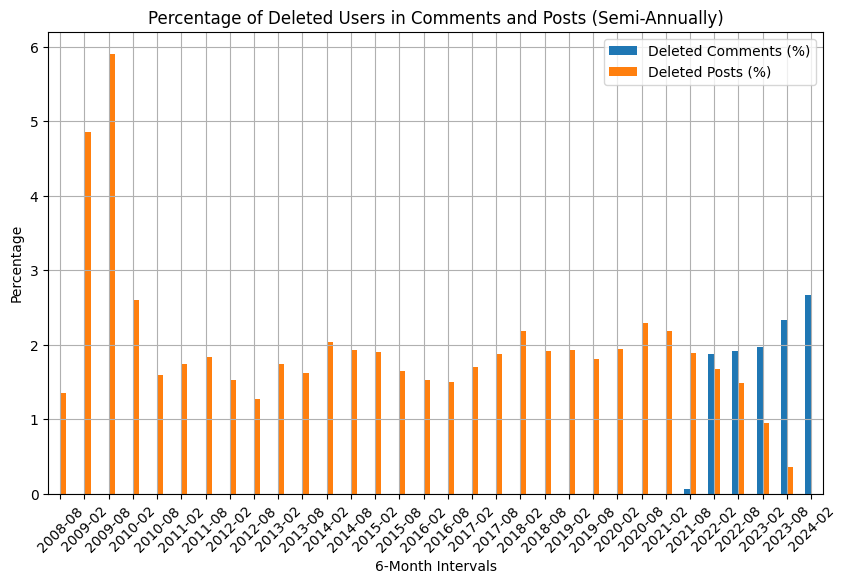

In [14]:
# Plotting the data
plt.figure(figsize=(10, 6))
semi_annual_percentage.plot(kind='bar', ax=plt.gca())
plt.title('Percentage of Deleted Users in Comments and Posts (Semi-Annually)')
plt.xlabel('6-Month Intervals')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Filtering before the storm

In [6]:
print(filtered_comments.shape)
print(filtered_active_posts_df.shape)

# Removing entries with -1 in UserId and OwnerUserId columns
#filtered_comments = filtered_comments[filtered_comments['UserId'] != -1]

filtered_active_posts_df = filtered_active_posts_df[filtered_active_posts_df['OwnerUserId'] != -1]

print(filtered_comments.shape)
print(filtered_active_posts_df.shape)

(42199170, 6)
(1865160, 14)
(42092110, 6)
(1797023, 14)


### Preprocess text

In [6]:
# Modify preprocess_text function
def preprocess_text(text, remove_stopwords=False, use_lemmatize=True, use_stemmer=False):
    # Handle None or non-string inputs
    if not isinstance(text, str):
        return ""
        
    # Decode HTML entities
    text = html.unescape(text)

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())

    words = text.split()
    if remove_stopwords:
        words = [word for word in words if word not in stopwords.words('english')]
    if use_lemmatize:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    elif use_stemmer:  # Apply stemming only if use_stemmer is True
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]

    text = ' '.join(words)
    
    return text

In [17]:
#Sample DFs for a pilot run
#filtered_active_posts_df = filtered_active_posts_df.sample(frac=0.001)
#filtered_comments_df = filtered_comments.sample(frac=

In [7]:
# Preprocess Title, Body, and Tags using Dask DataFrames
# Convert the DFs to Dask DataFrames
ddf_comments = dd.from_pandas(filtered_comments, npartitions=8)
ddf_posts = dd.from_pandas(filtered_active_posts_df, npartitions=8)

In [8]:
# Preprocess Columns
ddf_comments['Text_Processed'] = ddf_comments['Text'].map_partitions(lambda x: x.apply(lambda y: preprocess_text(y, remove_stopwords=True, use_lemmatize=True, use_stemmer=False)))

# Convert back to pandas DataFrame and save as pickle
df_comments_processed = ddf_comments.compute()
#df_comments_processed.to_pickle('df_comments_processed.pkl')

In [ ]:
# Preprocess Posts
ddf_posts['Title_Processed'] = ddf_posts['Title'].map_partitions(lambda x: x.apply(lambda y: preprocess_text(y, remove_stopwords=True, use_lemmatize=True, use_stemmer=False)))
ddf_posts['Body_Processed'] = ddf_posts['Body'].map_partitions(lambda x: x.apply(lambda y: preprocess_text(y, remove_stopwords=True, use_lemmatize=True, use_stemmer=False)))

In [ ]:
# Convert back to pandas DataFrame and save as pickle
df_posts_processed = ddf_posts.compute()
df_posts_processed.to_pickle('df_posts_processed.pkl')

### Estimate memory usage

In [9]:
# Initialize SentimentIntensityAnalyzer once
sia = SentimentIntensityAnalyzer()

# Function to apply sentiment analysis
def analyze_sentiment(text):
    # Check if the text is missing or NaN, return 0.0 in such cases
    if pd.isna(text):
        return 0.0
    # Ensure the text is encoded as a string
    text = str(text)
    return sia.polarity_scores(text)['compound']

In [ ]:
# def process_data(df, npartitions=None):
#     start_time = time.time()
#     
#     # If npartitions is not specified, default to 1 (suitable for sequential processing)
#     if npartitions is None:
#         npartitions = 1
# 
#     # Convert DataFrame to Dask DataFrame
#     ddf = dd.from_pandas(df, npartitions=npartitions)
#     # Apply sentiment analysis
#     ddf['sentiment'] = ddf['Body'].map(analyze_sentiment, meta=('Body', 'float64'))
# 
#     # Compute result and monitor memory usage
#     result = ddf.compute()
#     memory_usage = psutil.virtual_memory()
#     
#     end_time = time.time()
#     return result, end_time - start_time, memory_usage.used

# Sequential processing (no parallelism)
# print("Running sequentially...")
# seq_result, seq_time, _ = process_data(df_posts)
# print(f"Sequential processing time: {seq_time} seconds")
# 
# # Parallel processing with multiple cores
# core_counts = [2, 4, 6, 7, 8, 10]
# for cores in core_counts:
#     print(f"Running with {cores} cores...")
#     with Client(n_workers=cores, threads_per_worker=2) as client:  # Adjust threads_per_worker as needed
#         _, parallel_time, mem_usage = process_data(df_posts, npartitions=cores)
#         efficiency = seq_time / (cores * parallel_time)
#         print(f"Time with {cores} cores: {parallel_time} seconds, Efficiency: {efficiency}, Memory used: {mem_usage} bytes")

### Sentiment Analysis Time

In [10]:
# Convert pandas DataFrame to Dask DataFrame
df_comments_dask = dd.from_pandas(df_comments_processed, npartitions=8)  # Adjust npartitions based on memory usage results
#df_posts_dask = dd.from_pandas(df_posts_processed, npartitions=8)  # Adjust npartitions based on memory usage results

# Apply sentiment analysis
df_comments_dask['Text_sentiment'] = df_comments_dask['Text'].map(analyze_sentiment)

In [ ]:
#df_posts_dask['body_sentiment'] = df_posts_dask['Body'].map(analyze_sentiment)

In [ ]:
#df_posts_dask['title_sentiment'] = df_posts_dask['Title'].map(analyze_sentiment)

In [11]:
with ProgressBar():
    df_comments_result = df_comments_dask.compute()

[########################################] | 100% Completed | 27.48 ss


In [ ]:
# with ProgressBar():
#     df_posts_result = df_posts_dask.compute()

[########################################] | 100% Completed | 1.29 sms


In [12]:
df_comments_result.sort_values(by='Text_sentiment', ascending=False)

,Id,PostId,Score,Text,CreationDate,UserId,Text_Processed,Text_sentiment
38360009,56906645,34568862,0,"Hi Paul, I am not sure where you find the time...",2016-01-03 19:43:08.543,1671693,hi paul sure find time answer question thank m...,0.9917
24728857,36412576,23696753,0,Oh look it's finally working after 3 hours! Ev...,2014-05-16 14:05:58.440,3399642,oh look finally working 3 hour even though sti...,0.9898
80775184,122194928,69136504,0,"Wow, what an amazing explanation: very calm, c...",2021-09-10 19:45:27.787,16870652,wow amazing explanation calm clean step step e...,0.9897
6031197,8839325,7321948,0,Well I didn't want to do so because it's flame...,2011-09-07 07:54:37.877,11449,well want flamefest area let put like python p...,0.9888
82368062,124723172,70555259,1,"I do not know how to thank you to fit, when I ...",2022-01-02 12:24:51.603,15894995,know thank fit solve equation excited tear kno...,0.9876
...,...,...,...,...,...,...,...,...
36040546,53455188,23332492,1,Hi Paul - I found it difficult to find your ta...,2015-09-27 14:57:42.867,901641,hi paul found difficult find talk pycon 2006 m...,-0.9677
951759,1557278,1682509,0,"The risk with that method, for Windows anyway,...",2009-11-05 19:49:39.470,183575,risk method window anyway kill shell child pro...,-0.9682
51115460,75953884,44478509,0,I am back for a short time. Sorry i wrote the ...,2017-06-11 01:11:28.907,8016168,back short time sorry wrote code wrong way sim...,-0.9711
80104228,121123524,68534483,0,"the structure works, But, I'm not able to prop...",2021-07-26 20:39:43.713,7343922,structure work able properly capture sys exc i...,-0.9721


### Save Results

In [ ]:
df_comments_result.to_pickle('df_comments_result.pkl')
#df_posts_result.to_pickle('df_posts_result.pkl')

In [ ]:
#df_posts_result.columns

Index(['Id', 'PostTypeId', 'ParentId', 'AcceptedAnswerId', 'CreationDate',
       'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastActivityDate',
       'Title', 'Tags', 'AnswerCount', 'CommentCount', 'Title_Processed',
       'Body_Processed'],
      dtype='object')

In [13]:
avg_answer_sentiment = df_comments_result.groupby('PostId')['Text_sentiment'].mean().rename('AvgAnswerSentiment')
active_user_answers = active_user_answers.merge(avg_answer_sentiment, left_on='Id', right_on='PostId', how='left').fillna({'AvgAnswerSentiment': 0})

In [14]:
active_user_answers.sort_values(by='AvgAnswerSentiment', ascending=False)

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,AvgAnswerSentiment
82504,70555259,2,70554714,-1,2022-01-02 10:34:41.913,1,-1,<p>Vectors P1-&gt;P3 and P1-&gt;P2 are colline...,3080723,2022-01-02 10:34:41.913,Comment: N/A,Comment: N/A,-1,1,0.9876
71673,62112894,2,62112754,-1,2020-05-31 07:22:17.837,5,-1,<p>It does not work that way. <code>time.sleep...,5577765,2021-05-11 19:08:28.317,Comment: N/A,Comment: N/A,-1,1,0.9835
9251,8495292,2,8495222,-1,2011-12-13 19:53:03.127,1,-1,<p>Your <code>analyzer</code> argument to <cod...,914466,2011-12-13 19:53:03.127,Comment: N/A,Comment: N/A,-1,1,0.9812
75609,65098354,2,65093534,-1,2020-12-01 20:53:29.513,0,-1,<p>I changed it so you pass items into the obj...,2397865,2020-12-01 20:53:29.513,Comment: N/A,Comment: N/A,-1,1,0.9810
60888,54092820,2,54091439,-1,2019-01-08 13:25:31.710,5,-1,"<p>Processes require a function to run, which ...",5349916,2019-01-08 13:36:55.353,Comment: N/A,Comment: N/A,-1,1,0.9804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74138,63971509,2,5387299,-1,2020-09-19 17:24:58.627,1,-1,<p>One approach can be to let those sub tests ...,2373278,2021-02-05 18:25:28.770,Comment: N/A,Comment: N/A,-1,1,-0.9446
30664,27736500,2,27734527,-1,2015-01-02 01:49:06.950,1,-1,<p>You may use the built-in <code>map()</code>...,4333347,2015-01-02 16:48:40.017,Comment: N/A,Comment: N/A,-1,1,-0.9460
89977,76395059,2,76371195,-1,2023-06-03 07:49:14.690,1,-1,<p>The example below deomonstrates how to make...,17865804,2023-06-03 07:49:14.690,Comment: N/A,Comment: N/A,-1,1,-0.9529
56214,50499892,2,50472471,-1,2018-05-24 02:07:51.650,1,-1,<p>If you're starting your containers all at o...,5619724,2018-05-24 02:07:51.650,Comment: N/A,Comment: N/A,-1,1,-0.9538


In [15]:
# Get average answer sentiment for each user
user_avg_answer_sentiment = active_user_answers.groupby('OwnerUserId')['AvgAnswerSentiment'].mean().rename('AnswerSentiment')
active_users = active_users.merge(user_avg_answer_sentiment, left_on='Id', right_on='OwnerUserId', how='left').fillna({'AnswerSentiment': 0})

In [16]:
active_users

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,PostCount,CommentCount,AcceptedAnswerCount,AnswerCount,TotalActivity,AvgAnswerScore,AvgPostScore,AcceptedAnswerFraction,AnswerSentiment
0,2084503,1153,2013-02-18 19:06:41.313,2023-08-23 15:59:39.330,231,386,8,27.0,138.0,0.0,4.0,169.0,2.500000,1.259259,0.0,-0.009650
1,744616,9721,2011-05-09 06:10:47.587,2023-09-03 08:12:29.347,1438,504,212,4.0,566.0,0.0,1.0,571.0,2.000000,1.750000,0.0,0.283289
2,12163898,119,2019-10-04 10:11:58.590,2023-08-22 18:04:47.997,55,3,0,21.0,57.0,0.0,0.0,78.0,0.000000,0.142857,NaN,0.000000
3,260586,1952,2010-01-28 02:08:29.147,2023-08-03 05:35:13.130,137,178,9,1.0,74.0,0.0,0.0,75.0,0.000000,1.000000,NaN,0.000000
4,56524,18002,2009-01-18 23:46:41.330,2015-05-01 09:06:30.197,2161,158,132,0.0,747.0,0.0,1.0,748.0,0.000000,0.000000,0.0,0.490833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11805,2843835,3806,2013-10-03 17:49:40.513,2022-06-15 00:16:00.863,162,123,21,1.0,120.0,0.0,0.0,121.0,0.000000,0.000000,NaN,0.000000
11806,2344111,2732,2013-05-02 17:11:51.513,2023-08-31 17:27:10.120,1052,86,237,0.0,587.0,0.0,29.0,616.0,2.137931,0.000000,0.0,0.129063
11807,2893733,1799,2013-10-18 08:02:07.087,2023-09-01 14:11:31.870,203,1001,2,1.0,103.0,0.0,1.0,105.0,0.000000,1.000000,0.0,0.000000
11808,2732801,36610,2013-08-30 11:41:57.513,2023-07-20 17:40:02.430,3652,2485,1441,2.0,3767.0,0.0,19.0,3788.0,3.526316,2.500000,0.0,0.022782


In [27]:
active_user_answers[active_user_answers['OwnerUserId'] == 3980115]

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,AvgAnswerSentiment
30702,34275861,2,34275736,-1,2015-12-14 20:19:59.963,1,-1,"<p>In that folder structure, your path is wron...",3980115,2015-12-14 20:19:59.963,Comment: N/A,Comment: N/A,-1,1,0.4926
54090,56792508,2,56792345,-1,2019-06-27 13:48:32.717,1,-1,<p>The issue is that you're reusing the same v...,3980115,2019-06-27 13:48:32.717,Comment: N/A,Comment: N/A,-1,2,0.4178
